## Case Study 8: Phân loại 15 loại quần áo (Multiclass classification với Softmax)

- Mục tiêu: Xây dựng mô hình phân loại ảnh vào 15 lớp quần áo từ tập dữ liệu kết hợp (Fashion-MNIST mở rộng + dữ liệu tự thu thập).
- Yêu cầu:
  - Khám phá dữ liệu: kích thước ảnh, phân bố theo lớp.
  - Xây dựng mô hình CNN ≥ 7 lớp, đầu ra Softmax 15 lớp.
  - Huấn luyện, đánh giá (độ chính xác, báo cáo phân loại, ma trận nhầm lẫn).
  - Giải thích Softmax và Cross-Entropy.

Dữ liệu: `Clothes_Dataset` (15 thư mục con, mỗi thư mục là 1 lớp).


In [2]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Thiết lập để giảm lỗi OOM với oneDNN/MKL (chạy trước khi import TensorFlow)
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
print("Đã set TF_ENABLE_ONEDNN_OPTS=0. Hãy Restart Kernel rồi chạy lại từ đầu để áp dụng triệt để.")


Đã set TF_ENABLE_ONEDNN_OPTS=0. Hãy Restart Kernel rồi chạy lại từ đầu để áp dụng triệt để.


In [3]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Giảm tải bộ nhớ: thiết lập GPU memory growth (nếu có) và hạ cấu hình ảnh/batch
try:
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    if gpus:
        print("Đã bật memory growth cho GPU")
except Exception:
    pass

# Hạ kích thước ảnh và batch size để tránh OOM
IMG_SIZE = (160, 160)   # từ 224 -> 160
BATCH_SIZE = 8          # từ 32 -> 8
print(f"IMG_SIZE={IMG_SIZE}, BATCH_SIZE={BATCH_SIZE}")


IMG_SIZE=(160, 160), BATCH_SIZE=8


In [5]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# (Tùy chọn) Cài đặt thư viện nếu thiếu
# !pip install -q tensorflow matplotlib seaborn scikit-learn pandas pillow

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Sklearn for evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Tái lập kết quả
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Cấu hình hiển thị đồ thị
plt.style.use("seaborn-v0_8")
sns.set_theme(context="notebook", style="whitegrid")

# Đường dẫn dữ liệu (chỉnh nếu khác)
DATA_DIR = Path(r"D:/Programming/PTHTTM/TieuLuan/Case8-multiclass-classification-voi-softmax-phan-loai-15-loai-quan-ao/Clothes_Dataset")
assert DATA_DIR.exists(), f"Không tìm thấy thư mục dữ liệu: {DATA_DIR}"

# Cấu hình ảnh và huấn luyện
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2  # tách 20% cho validation (Keras hỗ trợ 2 tập: train/val)
AUTOTUNE = tf.data.AUTOTUNE


Số lớp: 15
Lớp: ['Blazer', 'Celana_Panjang', 'Celana_Pendek', 'Gaun', 'Hoodie', 'Jaket', 'Jaket_Denim', 'Jaket_Olahraga', 'Jeans', 'Kaos', 'Kemeja', 'Mantel', 'Polo', 'Rok', 'Sweter']


,class,count
0,Blazer,500
1,Celana_Panjang,500
2,Celana_Pendek,500
3,Gaun,500
4,Hoodie,500
5,Jaket,500
6,Jaket_Denim,500
7,Jaket_Olahraga,500
8,Jeans,500
9,Kaos,500


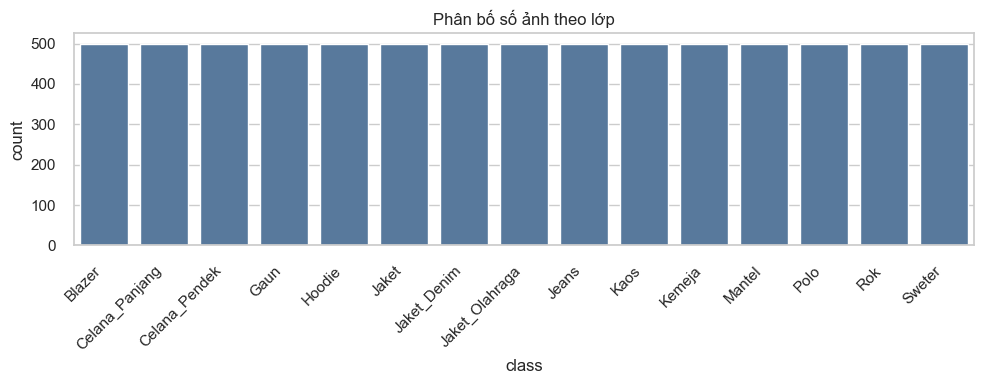

Thống kê kích thước (mẫu):


,count,mean,std,min,25%,50%,75%,max
width,1200.0,720.0,0.0,720.0,720.0,720.0,720.0,720.0
height,1200.0,1280.0,0.0,1280.0,1280.0,1280.0,1280.0,1280.0


C:\Users\Aspire 7\AppData\Local\Temp\ipykernel_13016\1793717645.py:47: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(dims_df["width"], label="width")
C:\Users\Aspire 7\AppData\Local\Temp\ipykernel_13016\1793717645.py:48: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(dims_df["height"], label="height")
C:\Users\Aspire 7\AppData\Local\Temp\ipykernel_13016\1793717645.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


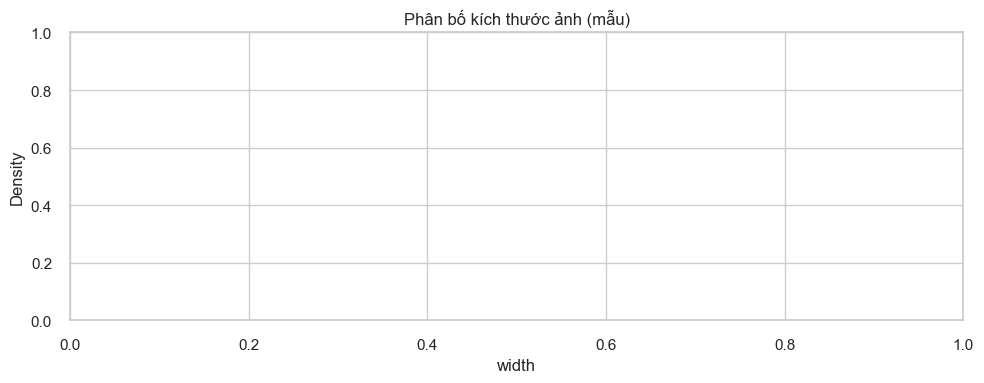

In [6]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Khám phá dữ liệu: danh sách lớp, số ảnh mỗi lớp, kích thước ảnh
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}
class_dirs = sorted([p for p in DATA_DIR.iterdir() if p.is_dir()])
class_names = [p.name for p in class_dirs]
print(f"Số lớp: {len(class_names)}\nLớp: {class_names}")

# Đếm số ảnh theo lớp
rows = []
for cdir in class_dirs:
    count = sum(1 for f in cdir.iterdir() if f.suffix.lower() in IMAGE_EXTS)
    rows.append({"class": cdir.name, "count": count})

counts_df = pd.DataFrame(rows).sort_values("class").reset_index(drop=True)
display(counts_df)

plt.figure(figsize=(10, 4))
sns.barplot(data=counts_df, x="class", y="count", color="#4C78A8")
plt.title("Phân bố số ảnh theo lớp")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Thống kê kích thước ảnh (lấy mẫu để nhanh hơn nếu dữ liệu lớn)
SAMPLE_PER_CLASS = 80
dims = []
for cdir in class_dirs:
    imgs = [f for f in cdir.iterdir() if f.suffix.lower() in IMAGE_EXTS]
    random.shuffle(imgs)
    for f in imgs[:SAMPLE_PER_CLASS]:
        try:
            with Image.open(f) as im:
                w, h = im.size
                dims.append({"class": cdir.name, "width": w, "height": h})
        except Exception:
            pass

if dims:
    dims_df = pd.DataFrame(dims)
    size_stats = dims_df[["width", "height"]].describe().T
    print("Thống kê kích thước (mẫu):")
    display(size_stats)

    plt.figure(figsize=(10, 4))
    sns.kdeplot(dims_df["width"], label="width")
    sns.kdeplot(dims_df["height"], label="height")
    plt.legend()
    plt.title("Phân bố kích thước ảnh (mẫu)")
    plt.tight_layout()
    plt.show()


In [7]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Tạo train/validation datasets từ thư mục
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Số lớp (suy ra): {num_classes}\n{class_names}")

# Tối ưu pipeline (bỏ cache cho train để giảm RAM, vẫn cache validation)
train_ds = train_ds.shuffle(1000, seed=SEED).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 7500 files belonging to 15 classes.
Using 6000 files for training.
Found 7500 files belonging to 15 classes.
Using 1500 files for validation.
Số lớp (suy ra): 15
['Blazer', 'Celana_Panjang', 'Celana_Pendek', 'Gaun', 'Hoodie', 'Jaket', 'Jaket_Denim', 'Jaket_Olahraga', 'Jeans', 'Kaos', 'Kemeja', 'Mantel', 'Polo', 'Rok', 'Sweter']


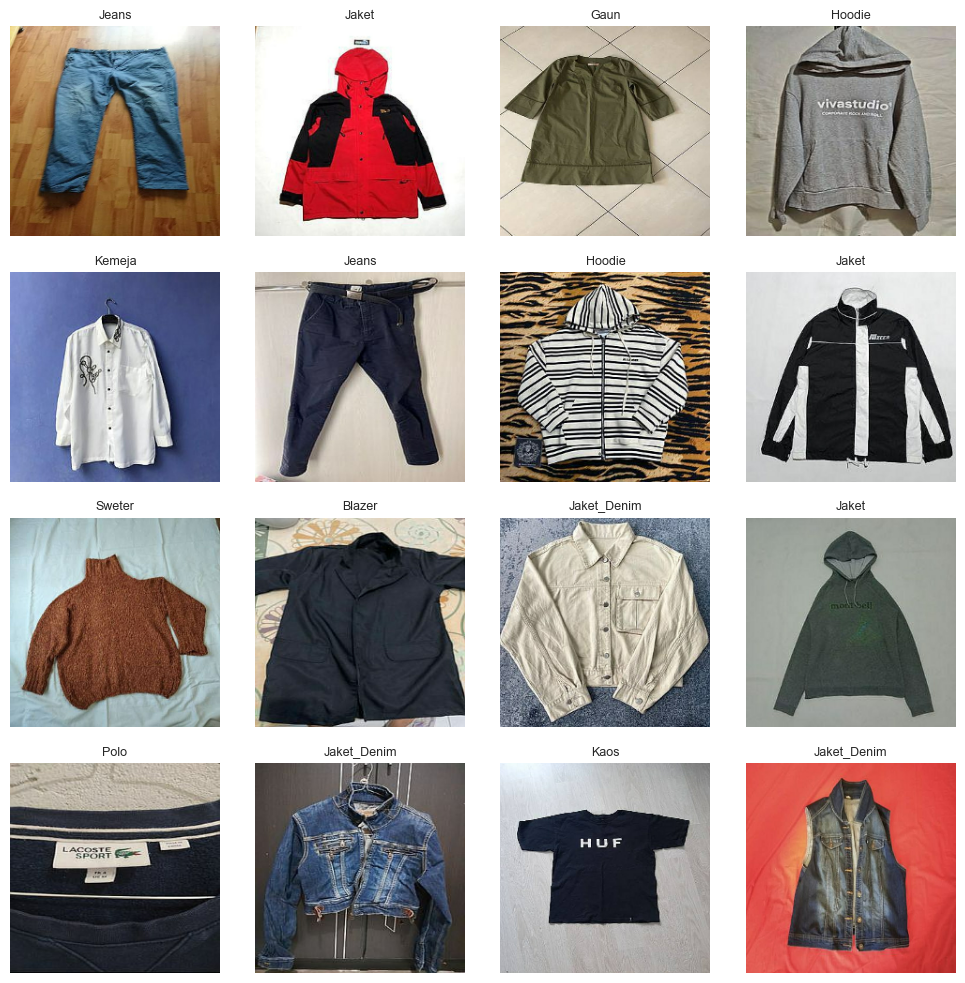

In [8]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Xem trước một batch ảnh với nhãn
class_idx_to_name = {i: n for i, n in enumerate(class_names)}

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = int(labels[i].numpy())
        plt.title(class_idx_to_name[label_idx], fontsize=9)
        plt.axis("off")
plt.tight_layout()
plt.show()


In [9]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Xây dựng mô hình CNN (>= 7 layers) với đầu ra Softmax 15 lớp

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_augmentation")

model = keras.Sequential([
    layers.InputLayer(input_shape=IMG_SIZE + (3,)),
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation='softmax')
], name="ClothesCNN")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

model.summary()


C:\Users\Aspire 7\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "ClothesCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 459,983 (1.75 MB)

 Trainable params: 459,023 (1.75 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.1302 - loss: 2.6992 - val_accuracy: 0.0560 - val_loss: 3.6013 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.1970 - loss: 2.4660 - val_accuracy: 0.0893 - val_loss: 2.9659 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - accuracy: 0.2235 - loss: 2.3841 - val_accuracy: 0.2327 - val_loss: 2.3658 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.2442 - loss: 2.3002 - val_accuracy: 0.1313 - val_loss: 2.6807 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 632s 3s/step - accuracy: 0.2652 - loss: 2.2414 - val_accuracy: 0.2560 - val_loss: 2.3882 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.3090 - loss: 2.1218 - val_accuracy: 0.2893 - val_loss: 2.2404 - learning_rate: 5.0000e-04
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - accuracy: 0.3193 - loss

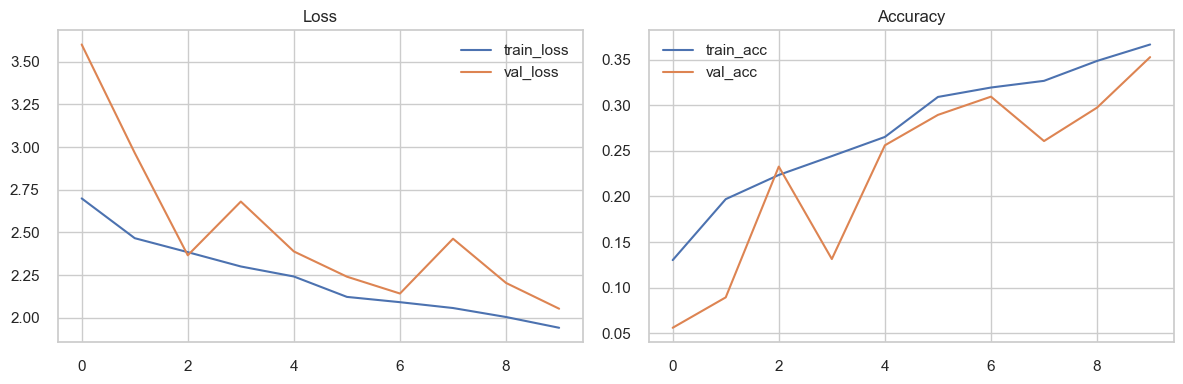

In [10]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Huấn luyện mô hình
EPOCHS = 10
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

# Biểu đồ loss/accuracy
hist_df = pd.DataFrame(history.history)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(hist_df['loss'], label='train_loss')
axes[0].plot(hist_df['val_loss'], label='val_loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[1].plot(hist_df['accuracy'], label='train_acc')
axes[1].plot(hist_df['val_accuracy'], label='val_acc')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.tight_layout()
plt.show()


In [ ]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Lưu mô hình và lịch sử huấn luyện
OUTPUT_DIR = Path("Case8-multiclass-classification-voi-softmax-phan-loai-15-loai-quan-ao") / "artifacts"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

model_path = OUTPUT_DIR / "clothes_cnn.keras"
history_path = OUTPUT_DIR / "train_history.csv"

model.save(model_path)
print(f"Đã lưu mô hình vào: {model_path}")

pd.DataFrame(history.history).to_csv(history_path, index=False)
print(f"Đã lưu lịch sử huấn luyện vào: {history_path}")


### Softmax và Cross-Entropy (Giải thích ngắn gọn)

- Softmax biến vector điểm số logit \(z = (z_1, \dots, z_K)\) thành phân phối xác suất \(p = (p_1, \dots, p_K)\):

\[ p_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}} \quad (i = 1,\dots, K) \]

- Với nhãn thật dạng chỉ số lớp \(y \in \{1, \dots, K\}\), hàm mất mát cross-entropy cho 1 mẫu là:

\[ \mathcal{L} = -\log p_{y} \]

- Trực giác: mô hình được khuyến khích gán xác suất cao cho lớp đúng (tối đa hóa \(p_y\) ⇔ tối thiểu hóa \(-\log p_y\)). Khi kết hợp qua mini-batch, ta lấy trung bình các \(\mathcal{L}\).

- Trong Keras, `SparseCategoricalCrossentropy(from_logits=False)` giả định đầu ra của mô hình đã là xác suất (đã qua Softmax). Nếu đầu ra là logit (chưa Softmax), dùng `from_logits=True` (và không thêm softmax ở lớp cuối).
